In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import matplotlib.pyplot as plt

import numpy as np
import spikeinterface.full as si

import pandas as pd
from pathlib import Path
base_folder = Path("H:\Work\SpikeSorting\kiehnlab\Treadmill_clustered_txt\Rec_treadmill_6OHDA_xx_-220615_VGlut2-ChR2-74_-220615-131834")

In [4]:
si.__version__


'0.100.6'

In [5]:
filename =  base_folder.name
recording_file_tev = base_folder / (filename+'.tev')
recording = si.read_tdt(recording_file_tev, stream_id = '0')
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_segments = recording.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")
recording

Channel ids: ['1']
Sampling frequency: 24414.0625
Number of channels: 1
Number of segments: 1


d:\Applications\anaconda3\envs\eeg\lib\site-packages\neo\rawio\tdtrawio.py:293: UserWarning: Could not identify sev files for channels [1, 1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8].
  warnings.warn(f"Could not identify sev files for channels {missing_sev_channels}.")


TdtRecordingExtractor: 1 channels - 24.4kHz - 1 segments - 72,642,560 samples 
                       2,975.44s (49.59 minutes) - float32 dtype - 277.11 MiB

In [6]:
from probeinterface import generate_linear_probe
from probeinterface.plotting import plot_probe

probe = generate_linear_probe(num_elec=1, ypitch=20, contact_shapes='circle', contact_shape_params={'radius': 6})

# the probe has to be wired to the recording
probe.set_device_channel_indices(np.arange(1))

recording = recording.set_probe(probe)
# plot_probe(probe)

In [7]:
manual_res = pd.read_csv(base_folder/ (filename+'.txt'),delimiter=',',skiprows=2,usecols=[0,2],names = ['time','cluster'],header=None)
manual_res['time_frames'] = round(manual_res['time'] * fs)
manual_res
manual_res = manual_res[manual_res['cluster'] != 0]
manual_res


,time,cluster,time_frames
0,0.006390,1,156.0
1,0.016835,1,411.0
4,0.036782,1,898.0
5,0.040550,1,990.0
7,0.053453,2,1305.0
...,...,...,...
195174,2975.303762,2,72639252.0
195175,2975.351194,1,72640410.0
195176,2975.399649,2,72641593.0
195177,2975.425290,2,72642219.0


In [8]:
sorting_true = si.NumpySorting.from_times_labels(manual_res['time_frames'].values,manual_res['cluster'].values,fs)
sorting_true.register_recording(recording)

In [7]:
sorting_true.get_total_samples()

72642560

In [9]:
job_kwargs = dict(n_jobs=4, chunk_duration='1s',  progress_bar=True)
recording_f = si.bandpass_filter(recording, freq_min=300, freq_max=7000)
we_true = si.extract_waveforms(recording_f, sorting_true, folder=os.path.join(base_folder,f"waveforms_true"),overwrite = True, sparse=False, **job_kwargs)

extract waveforms memmap multi buffer:   0%|          | 0/2976 [00:00<?, ?it/s]

In [ ]:
from spikeinterface.curation import remove_excess_spikes
from spikeinterface import extract_waveforms

def compute_moving_firing_rate_and_cv_isi(
    waveform_extractor,
    window_size_s=1.0,
    step_size_s=0.5,
    unit_ids=None,
):
    sorting = waveform_extractor.sorting
    sampling_frequency = waveform_extractor.sampling_frequency
    duration = waveform_extractor.get_total_duration()
    num_segs = sorting.get_num_segments()
    if unit_ids is None:
        unit_ids = sorting.unit_ids

    window_size_samples = int(window_size_s * sampling_frequency)
    step_size_samples = int(step_size_s * sampling_frequency)

    moving_firing_rates = {unit_id: [] for unit_id in unit_ids}
    moving_cv_isi = {unit_id: [] for unit_id in unit_ids}
    time_bins = []

    for unit_id in unit_ids:
        spike_train = []
        for seg_idx in range(num_segs):
            spike_train.extend(sorting.get_unit_spike_train(unit_id=unit_id, segment_index=seg_idx))
        spike_train = np.array(spike_train)

        start_sample = 0
        unit_time_bins = []  # Local timestamp list
        while start_sample + window_size_samples <= duration * sampling_frequency:
            end_sample = start_sample + window_size_samples
            window_spike_times = spike_train[
                (spike_train >= start_sample) & (spike_train < end_sample)
            ] / sampling_frequency
            firing_rate = len(window_spike_times) / window_size_s
            if len(window_spike_times) > 1:
                isi = np.diff(window_spike_times)
                cv_isi = np.std(isi) / np.mean(isi)
            else:
                cv_isi = np.nan

            moving_firing_rates[unit_id].append(firing_rate)
            moving_cv_isi[unit_id].append(cv_isi)
            unit_time_bins.append(start_sample / sampling_frequency)  # Add corresponding time point
            start_sample += step_size_samples

        # Synchronize timestamp length to the sliding window result of each unit
        time_bins.append(unit_time_bins)

    return time_bins, moving_firing_rates, moving_cv_isi

def plot_moving_metrics(time_bins, moving_firing_rates, moving_cv_isi):
    """
    Plot instantaneous firing rate and ISI coefficient of variation in a sliding window.

    Parameters
    ----------
    time_bins : list of list
        Sliding window timestamps for each unit.
    moving_firing_rates : dict
        Sliding window firing rate for each unit.
    moving_cv_isi : dict
        Sliding window ISI coefficient of variation for each unit.
    """
    for unit_id, unit_time_bins in zip(moving_firing_rates.keys(), time_bins):
        plt.figure(figsize=(6, 4))

        # Instantaneous firing rate
        plt.subplot(2, 1, 1)
        plt.plot(unit_time_bins, moving_firing_rates[unit_id], label=f"Unit {unit_id}",color=f"C{unit_id-1}")
        plt.ylabel("Firing Rate (Hz)")
        plt.title(f"Unit {unit_id} - Sliding Firing Rate")
        plt.legend()

        # Instantaneous CV ISI
        plt.subplot(2, 1, 2)
        plt.plot(unit_time_bins, moving_cv_isi[unit_id], label=f"Unit {unit_id}",color = f"C{unit_id-1}")
        plt.ylabel("CV ISI")
        plt.title(f"Unit {unit_id} - Sliding CV ISI")
        plt.legend()

        plt.xlabel("Time (s)")
        plt.tight_layout()
        plt.show()


In [ ]:
def plot_preprocessed_segment(waveform_extractor, start_time, end_time):
    recording = waveform_extractor.recording
    sampling_frequency = recording.get_sampling_frequency()
    start_sample = int(start_time * sampling_frequency)
    end_sample = int(end_time * sampling_frequency)
    segment = recording.get_traces(start_frame=start_sample, end_frame=end_sample)

    time_axis = np.arange(segment.shape[0]) / sampling_frequency + start_time
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, segment, c='k')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Preprocessed Recording (0-450 sec)")
    plt.show()


def plot_correlograms(waveform_extractor, window_ms=50, bin_ms=1):
    """
    Compute and plot the autocorrelogram for each unit.

    Parameters
    ----------
    waveform_extractor : WaveformExtractor
        WaveformExtractor object.
    window_ms : int, optional
        Time window for autocorrelation (milliseconds).
    bin_ms : int, optional
        Width of each time bin (milliseconds).
    """
    sorting = waveform_extractor.sorting
    sampling_frequency = waveform_extractor.recording.get_sampling_frequency()

    # Compute autocorrelogram
    correlograms, bins = compute_correlograms(
        waveform_or_sorting_extractor=sorting,
        window_ms=window_ms,
        bin_ms=bin_ms,
    )

    unit_ids = sorting.unit_ids
    num_units = len(unit_ids)

    # Plot autocorrelogram for each unit
    plt.figure(figsize=(6, num_units * 3))
    for i, unit_id in enumerate(unit_ids):
        plt.subplot(num_units, 1, i + 1)
        autocorr = correlograms[i, i, :]  # Autocorrelation is on the diagonal
        time_lags = bins[:-1]  # Time labels for each bin
        plt.bar(time_lags, autocorr, width=bin_ms, color=f"C{i}")
        plt.title(f"Autocorrelogram - Unit {unit_id}")
        plt.xlabel("Time lag (ms)")
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [ ]:
def create_waveform_subset(waveform_extractor, start_time, end_time):
    """
    Crop the recording to the specified time range and create a new WaveformExtractor.

    Parameters
    ----------
    waveform_extractor : WaveformExtractor
        The original WaveformExtractor object.
    start_time : float
        Start time (seconds).
    end_time : float
        End time (seconds).

    Returns
    -------
    new_waveform_extractor : WaveformExtractor
        The cropped WaveformExtractor object.
    """
    recording = waveform_extractor.recording
    sorting = waveform_extractor.sorting
    sampling_frequency = recording.get_sampling_frequency()

    # Convert time to sample indices
    start_sample = int(start_time * sampling_frequency)
    end_sample = int(end_time * sampling_frequency)

    # Crop the recording
    cropped_recording = recording.frame_slice(start_frame=start_sample, end_frame=end_sample)

    # Remove spikes outside the range
    cleaned_sorting = remove_excess_spikes(sorting, cropped_recording)

    # Create a new WaveformExtractor
    new_waveform_extractor = extract_waveforms(cropped_recording, cleaned_sorting, folder="waveform_subset",overwrite=True, sparse=False)
    return new_waveform_extractor


# wave1 = create_waveform_subset(we_true, 0, 450)

In [25]:
wave0 = create_waveform_subset(we_true, 0, 0.15)

extract waveforms memmap multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

In [14]:
time_bins, moving_firing_rates, moving_cv_isi = compute_moving_firing_rate_and_cv_isi(
    wave1,
    window_size_s=20.0,
    step_size_s = 1,
    unit_ids=sorting_true.unit_ids,
)

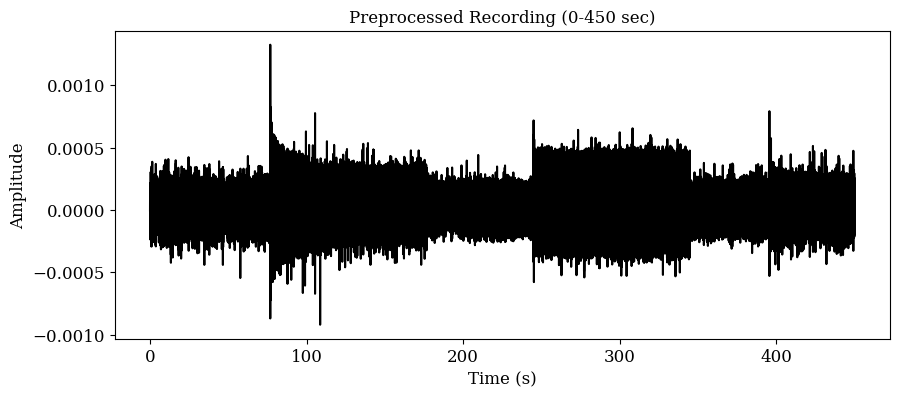

In [49]:
plot_preprocessed_segment(we_true, 0, 450)

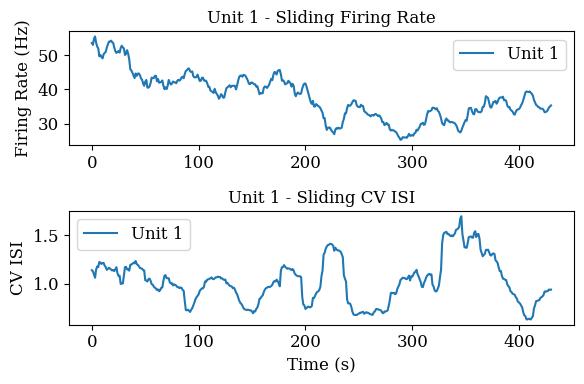

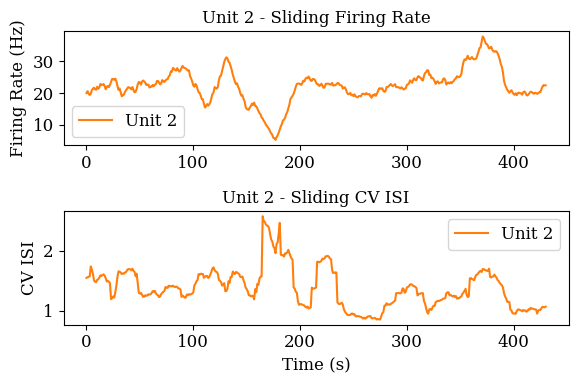

In [100]:
plot_moving_metrics(time_bins, moving_firing_rates, moving_cv_isi)

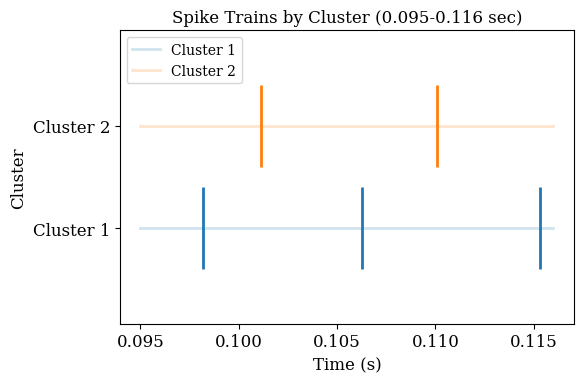

In [ ]:
def plot_spike_trains_by_cluster(waveform_extractor, start_time=0.095, end_time=0.116, line_width=0.5, zero_line_width=2):
    """
    Plot the spike raster for each cluster, and show a zero line where there are no spikes.
    
    Parameters
    ----------
    waveform_extractor : WaveformExtractor
        WaveformExtractor object.
    start_time : float, optional
        Start time (seconds), default is 0.0.
    end_time : float, optional
        End time (seconds), default is None, meaning plot until the end of the recording.
    line_width : float, optional
        Line width for each spike, default is 0.5.
    zero_line_width : float, optional
        Line width for the zero line when there are no spikes, default is 2.
    """
    sorting = waveform_extractor.sorting
    unit_ids = sorting.unit_ids
    sampling_frequency = waveform_extractor.recording.get_sampling_frequency()
    total_duration = waveform_extractor.recording.get_total_duration()

    # By default, plot until the end
    if end_time is None:
        end_time = total_duration

    plt.figure(figsize=(6, len(unit_ids) * 2))
    for i, unit_id in enumerate(unit_ids):
        spike_train = sorting.get_unit_spike_train(unit_id=unit_id)
        spike_train_seconds = spike_train / sampling_frequency

        # Restrict to the specified time window
        spike_times_in_window = spike_train_seconds[
            (spike_train_seconds >= start_time) & (spike_train_seconds <= end_time)
        ]

        # Plot zero line
        plt.plot(
            [start_time, end_time], 
            [i + 1, i + 1], 
            color=f"C{i}", 
            linewidth=zero_line_width, 
            alpha=0.2, 
            label=f"Cluster {unit_id}"
        )

        # Plot spikes
        plt.eventplot(
            spike_times_in_window,
            lineoffsets=i + 1,
            linelengths=0.8,
            linewidths=line_width,
            colors=f"C{i}"
        )

    plt.xlabel("Time (s)")
    plt.ylabel("Cluster")
    plt.yticks(range(1, len(unit_ids) + 1), labels=[f"Cluster {u}" for u in unit_ids])
    plt.title(f"Spike Trains by Cluster ({start_time}-{end_time} sec)")
    plt.legend(loc="upper left", fontsize="small")
    plt.tight_layout()
    plt.show()



plot_spike_trains_by_cluster(wave0, line_width=2, zero_line_width=2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def generate_unit_colors(unit_ids):
    """
    Generate a color dictionary based on unit IDs.

    Parameters
    ----------
    unit_ids : list or array-like
        List of unit IDs.

    Returns
    -------
    unit_colors : dict
        Color dictionary, keys are unit IDs, values are color strings.
    """
    num_units = len(unit_ids)
    cmap = plt.get_cmap('tab10' if num_units <= 10 else 'tab20')  # Choose appropriate colormap
    colors = [cmap(i / num_units) for i in range(num_units)]
    unit_colors = {unit_id: colors[i] for i, unit_id in enumerate(unit_ids)}
    return unit_colors

def plot_preprocessed_segment_with_spikes(waveform_extractor, start_time, end_time, line_width=0.7, spike_marker_size=10):
    """
    Plot the preprocessed recording signal and mark spike times of different units with different colors.

    Parameters
    ----------
    waveform_extractor : WaveformExtractor
        WaveformExtractor object.
    start_time : float
        Start time (seconds).
    end_time : float
        End time (seconds).
    line_width : float, optional
        Line width for the recording signal, default is 0.7.
    spike_marker_size : float, optional
        Marker size for spikes, default is 10.
    """
    recording = waveform_extractor.recording
    sorting = waveform_extractor.sorting
    sampling_frequency = recording.get_sampling_frequency()

    # Slice the recording signal
    start_sample = int(start_time * sampling_frequency)
    end_sample = int(end_time * sampling_frequency)
    segment = recording.get_traces(start_frame=start_sample, end_frame=end_sample)
    time_axis = np.arange(segment.shape[0]) / sampling_frequency + start_time

    # Get unit IDs and color dictionary
    unit_ids = sorting.unit_ids
    unit_colors = generate_unit_colors(unit_ids)

    plt.figure(figsize=(6, 3))

    # Plot the recording signal
    plt.plot(time_axis, segment, color="black", linewidth=line_width)

    # Mark spike positions
    for unit_id in unit_ids:
        spike_train = sorting.get_unit_spike_train(unit_id=unit_id)
        spike_train_seconds = spike_train / sampling_frequency
        spike_times_in_window = spike_train_seconds[
            (spike_train_seconds >= start_time) & (spike_train_seconds <= end_time)
        ]
        for spike_time in spike_times_in_window:
            plt.axvline(spike_time, color=unit_colors[unit_id], linestyle="--", alpha=0.8, linewidth=1)
        plt.scatter(
            spike_times_in_window,
            np.zeros_like(spike_times_in_window),  # Mark at zero line
            color=unit_colors[unit_id],
            label=f"Unit {unit_id}",
            s=spike_marker_size
        )

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Preprocessed Recording with Spike Times ({start_time}-{end_time} sec)")
    plt.legend(loc="upper left", fontsize="x-small")
    plt.tight_layout()
    plt.show()


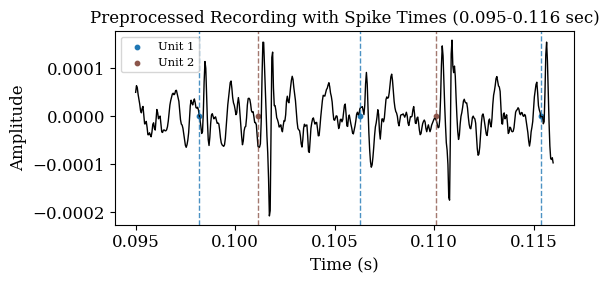

In [32]:
plot_preprocessed_segment_with_spikes(wave0, start_time=0.095, end_time=0.116, line_width=1, spike_marker_size=10)

In [43]:
from spikeinterface.postprocessing import compute_correlograms

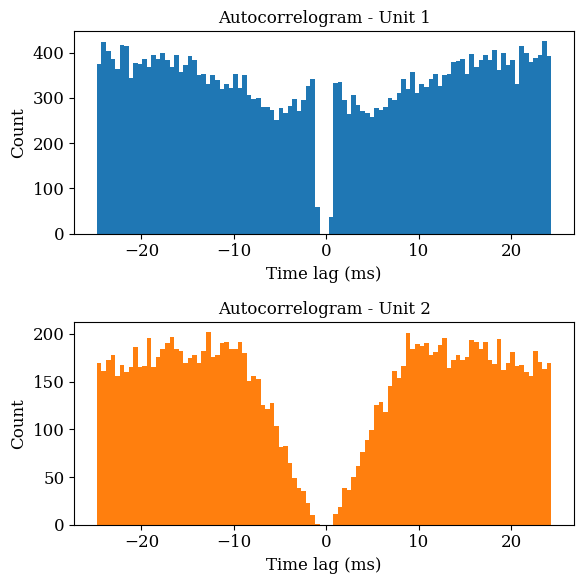

In [58]:
plot_correlograms(wave1, window_ms=50, bin_ms=0.5)

In [92]:
import spikeinterface.widgets as sw
import matplotlib.cm as cm

tab10 = cm.get_cmap('tab10')
unit_ids = wave0.sorting.unit_ids
unit_colors = {unit_id: tab10(i % 10) for i, unit_id in enumerate(unit_ids)}

def plot_waveform_overlay(waveform_extractor):
    sw.plot_unit_waveforms(waveform_extractor,same_axis = True,unit_colors = unit_colors, max_spikes_per_unit = 1000,alpha_templates = 0.8, x_offset_units = True,set_title = False)

    plt.show()


C:\Users\hughq\AppData\Local\Temp\ipykernel_11208\399616938.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = cm.get_cmap('tab10')


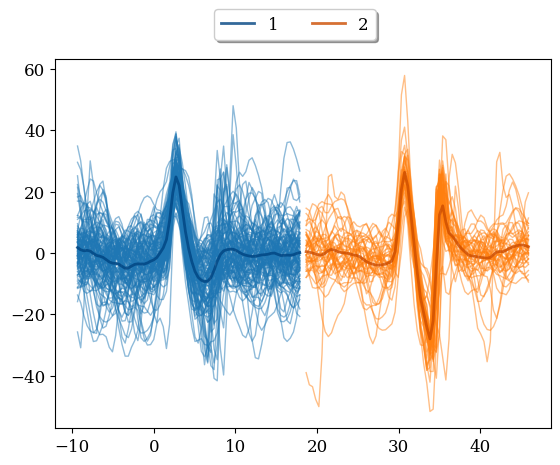

In [93]:
plot_waveform_overlay(wave0)